## In this notebook we test primitive ML methods for candidate generation  

In [1]:
import sys
sys.path.append('../')
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.decomposition import IncrementalPCA
import torch
import eeghdf
from sklearn import preprocessing

from primitives import *
from seizure_matrix import seizure_matrix
from tqdm import tqdm


FREQUENCY = 200
INCLUDED_CHANNELS = ['EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG C3', 'EEG C4', 'EEG P3', 'EEG P4',
'EEG O1', 'EEG O2', 'EEG F7', 'EEG F8', 'EEG T3', 'EEG T4', 'EEG T5', 'EEG T6', 'EEG Fz', 'EEG Cz', 'EEG Pz']

sys.path.append('../../EEG_end_model/')
from dataloader_utils import getChannelIndices, is_increasing, get_swap_pairs, random_augmentation, getSeizureTimes, sliceEpoch
import utils

TD_PRIMITIVE_FUNCTIONS = [td_mean, td_variance, td_skewness, td_kurtosis, td_coeff_var, td_medianAbsDeviationAmplitude,
                          td_rootMeanSquareAmplitude, td_interQuartileRange, td_shannon_entropy]
FD_PRIMITIVE_FUNCTIONS = [fd_max_power_band_front, fd_max_power_band_back, fd_spectralCentroid, fd_spectralFlatness,
                          fd_spectral_entropy]

BOLD = '\033[1m'
END = '\033[0m'

def get_features(signals):
    seizureMatrix = seizure_matrix(signals, TD_PRIMITIVE_FUNCTIONS, FD_PRIMITIVE_FUNCTIONS)
    featureMatrix = seizureMatrix.get_feature_matrix()
    return featureMatrix


ModuleNotFoundError: No module named 'future'

### write file markers for negative reports

In [3]:
with open('/home/ksaab/EEG/EEG_khaled/EEG_end_model/reports_lpch_dict.txt', 'rb') as f:
    report_dict = pickle.load(f)
    
file_markers = open('/home/ksaab/EEG/EEG_khaled/EEG_end_model/automated_file_markers/train_no_sz.txt','w')

for fn in report_dict:
    if report_dict[fn] < 0.5:
        file_markers.write("%s,%d\n" % (fn,-1))
    

## Extract 200 random silver labels

In [53]:
#features_dir = '/mnt/data/eeg/data/lpch/lpch_features/'
signals_dir =  '/mnt/data/eeg/data/lpch/lpch'
# file names are in .hdf5 format
#features_fn = os.listdir(features_dir)

num_silver = 500
num_silver_train = int(0.8*num_silver)

oversamp_num = 4
num_pos = int(0.2*num_silver_train) 
num_neg = num_silver_train-num_pos
num_train = num_pos*oversamp_num + num_neg

num_silver_dev = num_silver-num_silver_train
num_pos_dev = int(0.2*num_silver_dev)
num_neg_dev = num_silver_dev-num_pos_dev


# extract 200 random silver labels from annotations
# where we want 40 positive clips and 160 negative ones
cv_seed = 0
pos_silver_fn_dir = '../../EEG_end_model/old_file_markers/file_markers_khaled3/lpch_seizures_train.txt'
neg_silver_fn_dir = '../../EEG_end_model/old_file_markers/file_markers_khaled3/lpch_nonSeizures_train.txt'

pos_silver_data = []
pos_silver_contents = open(pos_silver_fn_dir, "r")
pos_silver_data.extend(pos_silver_contents.readlines())
pos_silver_fns = [entry.split(',')[0] for entry in pos_silver_data]
pos_silver_sz_times = [entry.split(',')[1] for entry in pos_silver_data]

neg_silver_data = []
neg_silver_contents = open(neg_silver_fn_dir, "r")
neg_silver_data.extend(neg_silver_contents.readlines())
neg_silver_fns = [entry.split(',')[0] for entry in neg_silver_data]


np.random.seed(cv_seed)
pos_ndxs = np.random.randint(low=0,high=len(pos_silver_data),size=num_pos)
neg_ndxs = np.random.randint(low=0,high=len(pos_silver_data),size=num_neg)

pos_ndxs_dev = np.random.randint(low=0,high=len(pos_silver_data),size=num_pos_dev)
neg_ndxs_dev = np.random.randint(low=0,high=len(pos_silver_data),size=num_neg_dev)

# oversamp
pos_ndxs = list(pos_ndxs)*oversamp_num
np.random.shuffle(pos_ndxs)

pos_val_fns = [pos_silver_fns[i] for i in pos_ndxs]
pos_val_sz_times = [pos_silver_sz_times[i] for i in pos_ndxs]
neg_val_fns = [neg_silver_fns[i] for i in neg_ndxs]


pos_val_fns_dev = [pos_silver_fns[i] for i in pos_ndxs_dev]
pos_val_sz_times_dev = [pos_silver_sz_times[i] for i in pos_ndxs_dev]
neg_val_fns_dev = [neg_silver_fns[i] for i in neg_ndxs_dev]



## Get features for the silver labels to train NN

In [54]:
X_train = np.zeros((num_train,551)) 
y_train = np.zeros((num_train,1))

X_dev = np.zeros((num_silver_dev,551)) 
y_dev = np.zeros((num_silver_dev,1))


features_avg = np.loadtxt('/home/ksaab/xmodal/EEG-sequence/model/features_avg.txt')
features_std = np.loadtxt('/home/ksaab/xmodal/EEG-sequence/model/features_std.txt')


#### Train sets ####
for i in tqdm(range(num_pos*oversamp_num),total=num_pos*oversamp_num):
    
    fn = pos_val_fns[i]
    sz_ndx = pos_val_sz_times[i]
    fn = os.path.join(signals_dir,fn)
    eegf = eeghdf.Eeghdf(fn)
    orderedChannels = getChannelIndices(eegf.electrode_labels)
    phys_signals = eegf.phys_signals
    seizureTimes = getSeizureTimes(eegf)
    
    # of shape 2400x19
    clip = sliceEpoch(orderedChannels, phys_signals, seizureTimes[int(sz_ndx)],True,12)
    # get real part 
    clip_features = (get_features(np.expand_dims(clip,0)).real)
    #remove nan
    clip_features[np.isnan(clip_features)] = 0
    #normalize
    eps=1e-5
    clip_features = (clip_features-features_avg)/(features_std+eps)
 
    X_train[i,:] = clip_features
    y_train[i] = 1 #positive label in metal
    
for i in tqdm(range(num_neg),total=num_neg):
    
    fn = neg_val_fns[i]
    sz_ndx = -1
    fn = os.path.join(signals_dir,fn)
    eegf = eeghdf.Eeghdf(fn)
    orderedChannels = getChannelIndices(eegf.electrode_labels)
    phys_signals = eegf.phys_signals
    
    # of shape 2400x19
    clip = sliceEpoch(orderedChannels, phys_signals, int(sz_ndx),True,12)
    # get real part 
    clip_features = (get_features(np.expand_dims(clip,0)).real)
    #remove nan
    clip_features[np.isnan(clip_features)] = 0
    #normalize
    eps=1e-5
    clip_features = (clip_features-features_avg)/(features_std+eps)
  
    X_train[i+num_pos*oversamp_num,:] = clip_features
    y_train[i+num_pos*oversamp_num] = 2 #neg label in metal
        
        
#### Dev sets ####
for i in tqdm(range(num_pos_dev),total=num_pos_dev):
    
    fn = pos_val_fns_dev[i]
    sz_ndx = pos_val_sz_times_dev[i]
    fn = os.path.join(signals_dir,fn)
    eegf = eeghdf.Eeghdf(fn)
    orderedChannels = getChannelIndices(eegf.electrode_labels)
    phys_signals = eegf.phys_signals
    seizureTimes = getSeizureTimes(eegf)
    
    # of shape 2400x19
    clip = sliceEpoch(orderedChannels, phys_signals, seizureTimes[int(sz_ndx)],True,12)
    # get real part 
    clip_features = (get_features(np.expand_dims(clip,0)).real)
    #remove nan
    clip_features[np.isnan(clip_features)] = 0
    #normalize
    eps=1e-5
    clip_features = (clip_features-features_avg)/(features_std+eps)
 
    X_dev[i,:] = clip_features
    y_dev[i] = 1 #positive label in metal
    
for i in tqdm(range(num_neg_dev),total=num_neg_dev):
    
    fn = neg_val_fns_dev[i]
    sz_ndx = -1
    fn = os.path.join(signals_dir,fn)
    eegf = eeghdf.Eeghdf(fn)
    orderedChannels = getChannelIndices(eegf.electrode_labels)
    phys_signals = eegf.phys_signals
    
    # of shape 2400x19
    clip = sliceEpoch(orderedChannels, phys_signals, int(sz_ndx),True,12)
    # get real part 
    clip_features = (get_features(np.expand_dims(clip,0)).real)
    #remove nan
    clip_features[np.isnan(clip_features)] = 0
    #normalize
    eps=1e-5
    clip_features = (clip_features-features_avg)/(features_std+eps)
  
    X_dev[i+num_pos_dev,:] = clip_features
    y_dev[i+num_pos_dev] = 2 #neg label in metal


  0%|          | 0/320 [00:00<?, ?it/s]/home/ksaab/miniconda2/envs/metal/lib/python3.6/site-packages/scipy/signal/signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]
../primitives.py:98: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.sum(np.nan_to_num(np.log(signals)), axis=2))**(1/m) * np.sum(signals, axis=2)
/home/ksaab/miniconda2/envs/metal/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
../primitives.py:118: RuntimeWarning: divide by zero encountered in log
  return 1 / signals.shape[2] * np.sum(np.nan_to_num(signals * np.log(signals)), axis = 2)
../primitives.py:118: RuntimeWarning: invalid value

## Reduce feature set usin PCA

In [203]:
X = np.zeros((num_silver_dev+num_train,551))
X[:num_train,:] = X_train
X[num_train:,:] = X_dev
transformer = IncrementalPCA(n_components=50)
X = np.nan_to_num(X) # remove nan
X_transformed = transformer.fit_transform(X)
print(X_transformed.shape)

#np.random.shuffle(X_transformed)
X_train_tr = X_transformed[:num_train,:]
X_dev_tr = X_transformed[num_train:,:] 
print('X train size: ',X_train_tr.shape)
print('X dev size: ',X_dev_tr.shape)


(740, 50)
X train size:  (640, 50)
X dev size:  (100, 50)


In [224]:
## save transformer

with open('pca_transformer.pkl','wb') as fp:
    pickle.dump(transformer,fp)

### Simple NN

In [204]:
import sys
sys.path.append('/home/ksaab/metal/')
#import warnings
#warnings.filterwarnings("ignore")

from metal.end_model import EndModel

end_model = EndModel([50,2],seed=123)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Linear(in_features=50, out_features=2, bias=True)
)



In [215]:
x_train = torch.from_numpy(X_train_tr.astype(np.float32))
x_dev = torch.from_numpy(X_dev_tr.astype(np.float32))


end_model.train_model((x_train, y_train),(x_dev, y_dev), lr = 0.001,l2=3, batch_size=128, 
                n_epochs=1000, print_every=100, validation_metric='precision', disable_prog_bar = True)

Saving model at iteration 0 with best score 0.229
[E:0]	Train Loss: 0.957	Dev score: 0.229
Saving model at iteration 1 with best score 0.235
Saving model at iteration 2 with best score 0.254
Saving model at iteration 6 with best score 0.260
Saving model at iteration 7 with best score 0.261
Saving model at iteration 13 with best score 0.265
Saving model at iteration 14 with best score 0.273
Saving model at iteration 22 with best score 0.276
Saving model at iteration 45 with best score 0.286
[E:100]	Train Loss: 0.560	Dev score: 0.269
Saving model at iteration 141 with best score 0.292
Saving model at iteration 165 with best score 0.320
Saving model at iteration 168 with best score 0.333
Saving model at iteration 184 with best score 0.348
Saving model at iteration 194 with best score 0.364
[E:200]	Train Loss: 0.545	Dev score: 0.364
[E:300]	Train Loss: 0.538	Dev score: 0.348
[E:400]	Train Loss: 0.533	Dev score: 0.348
[E:500]	Train Loss: 0.531	Dev score: 0.333
[E:600]	Train Loss: 0.528	Dev 

torch.Size([100, 50])
Roc-auc: 0.657
        y=1    y=2   
 l=1     8     14    
 l=2    12     66    
AUC: 0.657
Recall Score: 0.150
Precision Score: 1.000
F1-Score: 0.261
Accuracy: 0.830


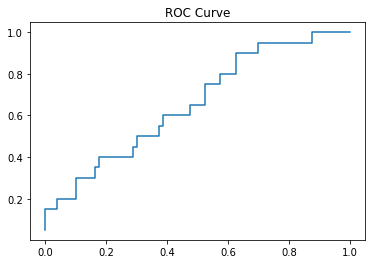

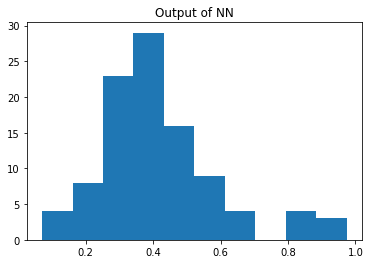

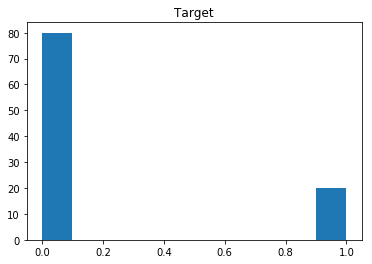

In [221]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_curve

print(x_dev.shape)
x_test = x_dev        
test_labels = y_dev
score = end_model.score((x_test, test_labels),metric='roc-auc')


target = []
for lb in test_labels:
    if lb == 1:
        target.append(1)
    else:
        target.append(0)
        
#print(target.shape)
proba = end_model.predict_proba(x_test)
outputs = proba[:,0]
thresh = 0.9
print('AUC: %.3f' % roc_auc_score(target,outputs))
print('Recall Score: %.3f' % recall_score(target,outputs>thresh))
print('Precision Score: %.3f' % precision_score(target,outputs>thresh))
print('F1-Score: %.3f' % f1_score(target,outputs>thresh))
print('Accuracy: %.3f' % accuracy_score(target,outputs>thresh))

#print('Unique values in output: ', np.unique(outputs))


fpr, tpr, thresholds = roc_curve(target, outputs, pos_label=1)
plt.title('ROC Curve')
plt.plot(fpr,tpr)
plt.show()
plt.title('Output of NN')
plt.hist(outputs)
plt.show()
plt.title('Target')
plt.hist(target)
plt.show()



### Save model

In [223]:
with open('nn_can_extractor.pkl','wb') as fp:
    pickle.dump(end_model,fp)

## Generate Candidates

In [12]:
proba = end_model.predict_proba(x_test)
print(proba.shape)

(1301, 2)


### Get gold file names

In [13]:
lpch_gold_file_names = []
import csv
with open('../start-stop-clips-sec-0.1.tsv','rt') as f:
    tsvin = csv.reader(f, delimiter='\t')
    for i,row in enumerate(tsvin):
        if i > 0:
            file_name = row[0]
            institute = file_name.split('/')[0]
            eeg_file_name = file_name.split('/')[1]
            if institute == 'lpch':
                lpch_gold_file_names.append(eeg_file_name)
print(len(lpch_gold_file_names))

522


### Get pos labels from reports

In [14]:
with open('../EEG_end_model/reports_lpch_dict.txt', 'rb') as f:
    reports_dict = pickle.load(f)
    
pos_reports_file_names = []
for fn in reports_dict:
    if reports_dict[fn] > 0.5:
        pos_reports_file_names.append(fn)
len(pos_reports_file_names)

8923

### Iterate through all clips

In [15]:
json_path = os.path.join('params.json')
params = utils.Params(json_path)

threshold = 0.6
num_cand = 0 #count how many candidates
total_clips = 0
failed_files = 0

data_dir = '/lfs/1/ksaab/data/eeg/lpch/'

#filter gold labelled files
file_names_ = pos_reports_file_names

#filter gold labelled files
file_names = []
for f in file_names_:
    if not(f in lpch_gold_file_names):
        file_names.append(f)


candidate_tupes = []

#file_markers = open('candidates.txt', 'a')

#for i,file_name in tqdm(enumerate(file_names)):
for i in tqdm(range(len(file_names))):
    
    file_name = file_names[i]
    
    # open EEG signal
    currentFileName = os.path.join(data_dir, file_name)
    
    eegf = eeghdf.Eeghdf(currentFileName)
    try:
        orderedChannels = getChannelIndices(eegf.electrode_labels)
    except ValueError:
        failed_files+=1
        continue
        
    signals = eegf.phys_signals
    
    #maxStart = max(signals.shape[1] - FREQUENCY * params.clip_len, 0)
    num_clips = int(signals.shape[1]/(FREQUENCY * params.clip_len))
    total_clips += num_clips

    output_list = []
    for clip_ndx in range(num_clips):
        
        startTime = int(FREQUENCY * clip_ndx)
        endTime = startTime + int(FREQUENCY * params.clip_len)
        
        if(not is_increasing(orderedChannels)):  
            sliceMatrix = signals[:,startTime:endTime] 
            sliceMatrix = sliceMatrix[orderedChannels, :]
        else:
            sliceMatrix = (signals.s2u[orderedChannels] \
                       * signals.data[orderedChannels, startTime:endTime].T).T
        
        input = torch.FloatTensor(sliceMatrix)
        input = input.cuda()
        input = input.unsqueeze(0)
        input=input.permute(0,2,1)
        x_features = get_features(input)
        x_features = np.nan_to_num(x_features) # remove nan
        x_input = transformer.transform(x_features)
        
        # get prediction on clip
       
        x_input = x_input.astype(np.float32)
        x_input = scaler.transform(x_input)
        output = end_model.predict_proba(torch.from_numpy(x_input))
        output = output[0][0]
        output_list.append(output)
        
        
        #if output > 0.5:
        #    print(BOLD + str(output) + END)
        #else:
        #    print(output)
     
    if num_clips > 0:
        sz_clip_ndx = np.argmax(output_list)
        pred = output_list[sz_clip_ndx]
        
        if pred > 0.49:
            startTime = int(FREQUENCY * sz_clip_ndx)
            num_cand +=1
            #file_markers.write("%s,%d\n" % (file_name,startTime))
            #candidate_tupes.append((file_name,startTime))

    break

        
   
     
    
     
print('Total candidates: ',num_cand)
print('Total clips: ',total_clips)
print('Failed files: ',failed_files)
    
#file_markers.close()


  0%|          | 0/8923 [00:00<?, ?it/s]

Total candidates:  1
Total clips:  164
Failed files:  0


### DataLoader Version

In [1]:
sys.path.append('cand_extractor/')
from data_loader_all_clips import fetch_dataloader

!export CUDA_VISIBLE_DEVICES=0


json_path = os.path.join('params.json')
params = utils.Params(json_path)

params.batch_size = 200
params.num_workers = 32
data_dir = '/lfs/1/ksaab/data/eeg/lpch/'

# use GPU if available
params.cuda = torch.cuda.is_available()
data_shape = (int(params.clip_len) * 200, 19)

dl = fetch_dataloader(data_dir, params, True, params.clip_len)



NameError: name 'sys' is not defined

In [5]:
import warnings
warnings.filterwarnings("ignore")

num_cand = 0 #count how many candidates
total_clips = 0
failed_files = 0


candidate_tupes = []

file_markers = open('/lfs/1/ksaab/eeg/LFs_on_Signals/cand_extractor/candidates_dl_dump.txt', 'w')

for i, (input_batch,fn_batch,st_batch) in tqdm(enumerate(dl)):
    
        
    input_batch = input_batch.squeeze()
    output = end_model.predict_proba(input_batch)
    output = output[:,0]
    
    #for i,pred in enumerate(output):
        
    #    fn = fn_batch[i]
    #    st = st_batch[i].item()
    #    if pred > 0.9:
            
    #        num_cand +=1
    #        file_markers.write("%s,%d\n" % (fn,st))
            #candidate_tupes.append((file_name,startTime))

        
   
     
    
     
print('Total candidates: ',num_cand)
print('Total clips: ',total_clips)
print('Failed files: ',failed_files)
    
file_markers.close()

0it [00:00, ?it/s]/lfs/1/ksaab/miniconda2/envs/metal/lib/python3.6/site-packages/scipy/signal/signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]
/lfs/1/ksaab/miniconda2/envs/metal/lib/python3.6/site-packages/scipy/signal/signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]
/lfs/1/ksaab/miniconda2/envs/metal/lib/python3.6/site-packages/scipy/signal/signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `

NameError: name 'end_model' is not defined

../primitives.py:42: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sqrt(td_variance(signals)) / td_mean(signals))
../primitives.py:111: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(np.nan_to_num(signals * np.log2(signals)), axis = 2)
../primitives.py:111: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.nan_to_num(signals * np.log2(signals)), axis = 2)
../primitives.py:90: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(multipliers * np.abs(signals), axis=2) / np.sum(np.abs(signals), axis=2)
../primitives.py:42: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sqrt(td_variance(signals)) / td_mean(signals))
../primitives.py:111: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(np.nan_to_num(signals * np.log2(signals)), axis = 2)
../primitives.py:111: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.nan

In [ ]:
print(sys.path)

In [ ]:
sys.path.append('/lfs/1/ksaab/eeg/LFs_on_Signals/cand_extractor/')
!jupyter nbconvert --to script cand_extractor.ipynb